# ネットワークの作成
## 手順
1. ネットワークの作成
2. 信用度の算出
3. 可視化、数値の算出

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import random
from sklearn.cluster import KMeans
import statsmodels.api as sm
import scipy as sp
from sklearn.linear_model import LogisticRegression

## [1]ネットワークの作成
1. 頂点の設定
2. 優先的選択ネットワークの作成
3. スモールワールドネットワークの作成

### ①頂点の設定
- 頂点数：300
- 高信頼者の割合：70%
#### データフォーマット
- trust：1＝高信頼者、0＝低信頼者
- group：所属しているグループやコミュニティ(0から3グループ)
- nft：関心のあるNFTの種類(0から

In [2]:
n = 1000
p_trust = 0.5
p_group = 0.25
p_nft = 0.2
color = ["blue", "red", "green", "yellow", "orange"]

In [3]:
trust_list = list()
group_list = list()
nft_list = list()
a_list = list()

for i in range(1, n+1):

    # 信頼度の割り当て
    if random.random() < p_trust:
        trust_list.append(1)
    else:
        trust_list.append(0)

    # グループの割り当て(0~3)
    group = random.random() / p_group
    group_list.append(int(group))

    # 興味のあるNFTの割り当て(0~4)
    nft = random.random() / p_nft
    nft_list.append(int(nft))

    # 魅力度
    a_list.append(random.random())


In [4]:
data = [[] for i in range(n)]
for i, (t, g, n, a) in enumerate(zip(trust_list, group_list, nft_list, a_list)):
    data[i] = [t, g, n, 0.0, 0.0, 0.0, a]

In [5]:
df = pd.DataFrame(
    data=data,
    columns=["trust", "group", "nft", "degree", "betweenness", "pagerank", "A"],
)
df.head()

,trust,group,nft,degree,betweenness,pagerank,A
0,1,1,4,0.0,0.0,0.0,0.184660
1,0,3,2,0.0,0.0,0.0,0.786906
2,0,3,3,0.0,0.0,0.0,0.547987
3,0,2,1,0.0,0.0,0.0,0.258623
4,0,3,0,0.0,0.0,0.0,0.289600


### ②優先的選択ネットワークの作成
$$
    P(j) = \frac{A_j + d_j} {\sum_{i=0}^{n}(A_n + d_n)}
$$

- A(attractiveness)：魅力度、関心事が一致した数
- $ \alpha $：非線型度合い $ \alpha(X) = \sum_{i=0}^{1}(\theta^X(1-\theta)) $

In [6]:
G = nx.DiGraph()
n = len(df)
num_edges = 0

# Add new nodes one by one with preferential attachment
for new_node in range(n):
    # パラメータの設定    
    G.add_node(new_node)
    A = df.at[new_node, "A"]

    for target_node in range(G.number_of_nodes()):
        if new_node == target_node: # 自分同士の取引なら無視する
            continue
        
        p = (A + G.degree(target_node)) / (A + num_edges)
        if (p > random.random()): # 確率に従って取引をするかどうかを判断する
            G.add_edge(new_node, target_node)
            num_edges += 1
# print(groups, ":", sum(groups))
# print(nfts, ":", sum(nfts))

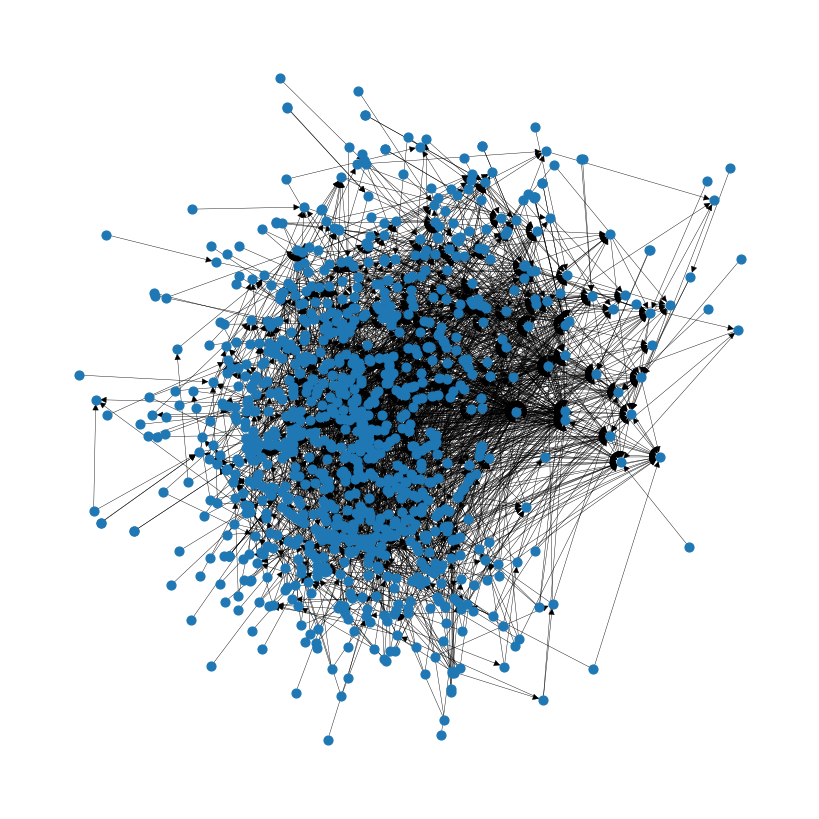

In [7]:
plt.figure(figsize=(8, 8))
nx.draw_kamada_kawai(G, node_size=40, with_labels=False, width=0.3)
# nx.draw(G, node_size=40, with_labels=False, width=0.3)
plt.savefig("data/graph.png")
plt.show()

頂点数：1000、辺数：2236
平均次数：2.236、最大次数：111
平均クラスター係数：0.01057522523528843


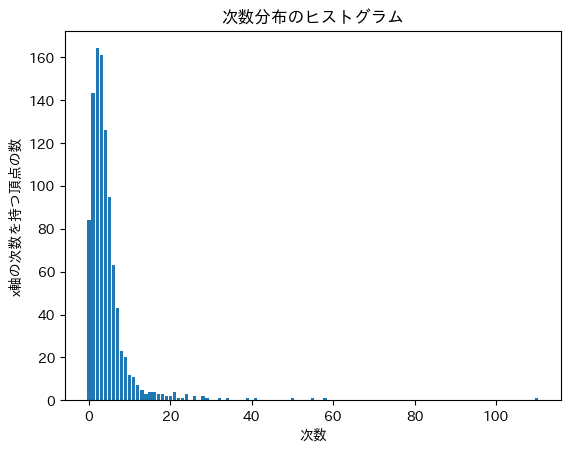

In [8]:
hist = nx.degree_histogram(G)
value = nx.clustering(G).values()
print(f"頂点数：{G.number_of_nodes()}、辺数：{G.number_of_edges()}")
print(f"平均次数：{G.number_of_edges()/G.number_of_nodes()}、最大次数：{len(hist)}")
print(f"平均クラスター係数：{sum(value)/len(value)}")

plt.bar(range(len(hist)), hist)
plt.title("次数分布のヒストグラム")
plt.xlabel("次数")
plt.ylabel("x軸の次数を持つ頂点の数")
plt.savefig("data/histogram.png")
plt.show()

## [2]信用度の算出
1. 優先的選択ネットワーク
2. スモールワールドネットワーク

In [9]:
def calc_score(v, name):
    temp = np.zeros(len(v))
    for key in v:
        temp[key] = v[key]
    df[name] = temp

### ①優先的選択ネットワーク

In [10]:
# 次数中心性
v = nx.in_degree_centrality(G)
calc_score(v, "degree")
# 媒介中心性
v = nx.betweenness_centrality(G)
calc_score(v, "betweenness")
# PageRank
v = nx.pagerank(G, max_iter=1000)
calc_score(v, "pagerank")

In [11]:
df.to_csv("data/data.csv")
df.head()

,trust,group,nft,degree,betweenness,pagerank,A
0,1,1,4,0.110110,0.000000,0.138123,0.184660
1,0,3,2,0.027027,0.000030,0.048830,0.786906
2,0,3,3,0.056056,0.000325,0.027503,0.547987
3,0,2,1,0.019019,0.000158,0.029472,0.258623
4,0,3,0,0.007007,0.000010,0.006152,0.289600


## 可視化、数値の算出

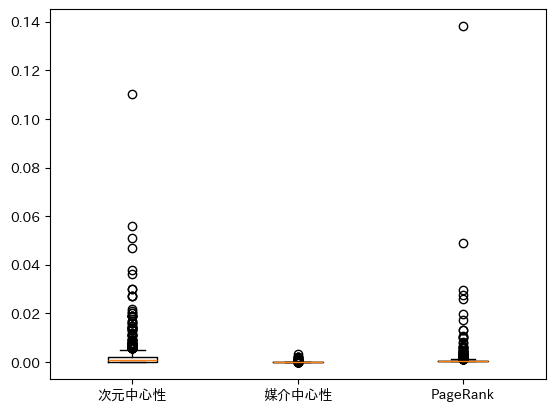

In [12]:
plt.boxplot(df[["degree", "betweenness", "pagerank"]], labels=["次元中心性", "媒介中心性", "PageRank"])
plt.savefig("data/box-plot.png")
plt.show()

In [13]:
n = len(df)
print("平均値")
print(df[["degree", "betweenness", "pagerank"]].mean(numeric_only=True))
print("-" * 50)

print("標準偏差")
print(df[["degree", "betweenness", "pagerank"]].std(numeric_only=True))
print("-" * 50)

print("最大値")
print(df[["degree", "betweenness", "pagerank"]].max(numeric_only=True))
print("-" * 50)

print("最小値")
print(df[["degree", "betweenness", "pagerank"]].min(numeric_only=True))

平均値
degree         0.002238
betweenness    0.000072
pagerank       0.001000
dtype: float64
--------------------------------------------------
標準偏差
degree         0.005922
betweenness    0.000217
pagerank       0.005029
dtype: float64
--------------------------------------------------
最大値
degree         0.110110
betweenness    0.003161
pagerank       0.138123
dtype: float64
--------------------------------------------------
最小値
degree         0.000000
betweenness    0.000000
pagerank       0.000301
dtype: float64


## クラスタリング
- ロールは4つに分けられる
- 中心性で算出された4つの範囲の最大値でロールを割り振る
- 低いロールのユーザは高いロールのユーザと取引ができないようにする

In [14]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit(df[["degree", "betweenness", "pagerank"]])
df['cluster'] = clusters.labels_

In [15]:
df.head()

,trust,group,nft,degree,betweenness,pagerank,A,cluster
0,1,1,4,0.110110,0.000000,0.138123,0.184660,2
1,0,3,2,0.027027,0.000030,0.048830,0.786906,1
2,0,3,3,0.056056,0.000325,0.027503,0.547987,1
3,0,2,1,0.019019,0.000158,0.029472,0.258623,1
4,0,3,0,0.007007,0.000010,0.006152,0.289600,3


In [16]:
cluster_counts = df['cluster'].value_counts()
for i in range(4):
    print(i, cluster_counts[i])
    print(df[["degree", "betweenness", "pagerank"]][df["cluster"] == i].sum() / cluster_counts[i])

0 904
degree         0.000989
betweenness    0.000031
pagerank       0.000454
dtype: float64
1 11
degree         0.035308
betweenness    0.000537
pagerank       0.019992
dtype: float64
2 1
degree         0.110110
betweenness    0.000000
pagerank       0.138123
dtype: float64
3 84
degree         0.010070
betweenness    0.000445
pagerank       0.002751
dtype: float64


## 評価
- 相関分析
- 多項ロジスティック分析

In [17]:
# 相関係数
df_corr = df[["degree", "betweenness", "pagerank"]].corr()
print(df_corr)

               degree  betweenness  pagerank
degree       1.000000     0.490296  0.816886
betweenness  0.490296     1.000000  0.161692
pagerank     0.816886     0.161692  1.000000
